# BIG DATA ASSIGNMENT WEEK 13
## Clustering
- Name: Kurnia Cahya Febryanto
- Student ID: 5025201073
- Class: Big Data A
- Lecturer: Abdul Munif, S.Kom., M.Sc.

## Reference
- https://runawayhorse001.github.io/LearningApacheSpark/clustering.html
- Part I: https://medium.com/@josephgeorgelewis2000/end-to-end-pyspark-clustering-part-i-using-colab-for-pyspark-and-collecting-data-6b94b58baeab
- Part II: https://medium.com/@josephgeorgelewis2000/end-to-end-pyspark-clustering-part-ii-preprocessing-and-model-building-in-colab-1c2d0d8f2a23

## Clustering Reference 1
#### Reference Runawayhorse001



### K-Means Model
#### Introduction
k-means clustering is a method of vector quantization, originally from signal processing, that is popular for cluster analysis in data mining. The approach k-means follows to solve the problem is called Expectation-Maximization. It can be described as follows:
1. Assign some cluter centers
2. Repeated until converged
    - E-Step: assign points to the nearest center
    - M-step: set the cluster center to the mean


### Demo

#### Set up spark context and SparkSession

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark K-means example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

#### Load dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Iris.csv to Iris (2).csv


In [ ]:
!ls

'Iris (1).csv'	'Iris (2).csv'	 Iris.csv   sample_data


In [ ]:
df = spark.read.format('csv') \
               .options(header='true', inferschema='true') \
               .load("Iris.csv", header=True)

check the data set

In [ ]:
df.show(5,True)
df.printSchema()

+---+-------------+------------+-------------+------------+-----------+
| Id|SepalLengthCm|SepalWidthCm|PetalLengthCm|PetalWidthCm|    Species|
+---+-------------+------------+-------------+------------+-----------+
|  1|          5.1|         3.5|          1.4|         0.2|Iris-setosa|
|  2|          4.9|         3.0|          1.4|         0.2|Iris-setosa|
|  3|          4.7|         3.2|          1.3|         0.2|Iris-setosa|
|  4|          4.6|         3.1|          1.5|         0.2|Iris-setosa|
|  5|          5.0|         3.6|          1.4|         0.2|Iris-setosa|
+---+-------------+------------+-------------+------------+-----------+
only showing top 5 rows

root
 |-- Id: integer (nullable = true)
 |-- SepalLengthCm: double (nullable = true)
 |-- SepalWidthCm: double (nullable = true)
 |-- PetalLengthCm: double (nullable = true)
 |-- PetalWidthCm: double (nullable = true)
 |-- Species: string (nullable = true)



You can also get the Statistical resutls from the data frame (Unfortunately, it only works for numerical).

In [ ]:
df.describe().show()

+-------+------------------+------------------+-------------------+------------------+------------------+--------------+
|summary|                Id|     SepalLengthCm|       SepalWidthCm|     PetalLengthCm|      PetalWidthCm|       Species|
+-------+------------------+------------------+-------------------+------------------+------------------+--------------+
|  count|               150|               150|                150|               150|               150|           150|
|   mean|              75.5| 5.843333333333335| 3.0540000000000007|3.7586666666666693|1.1986666666666672|          null|
| stddev|43.445367992456916|0.8280661279778637|0.43359431136217375| 1.764420419952262|0.7631607417008414|          null|
|    min|                 1|               4.3|                2.0|               1.0|               0.1|   Iris-setosa|
|    max|               150|               7.9|                4.4|               6.9|               2.5|Iris-virginica|
+-------+------------------+----

#### Convert the data to dense vector (features)

In [ ]:
# convert the data to dense vector
from pyspark.ml.linalg import Vectors

def transData(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[:-1])]).toDF(['features'])

You are strongly encouraged to try my `get_dummy` function for dealing with the categorical data in complex dataset.

Supervised learning version:

In [ ]:
def get_dummy(df,indexCol,categoricalCols,continuousCols,labelCol):

    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
    from pyspark.sql.functions import col

    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in categoricalCols ]

    # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                 outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers ]

    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                + continuousCols, outputCol="features")

    pipeline = Pipeline(stages=indexers + encoders + [assembler])

    model=pipeline.fit(df)
    data = model.transform(df)

    data = data.withColumn('label',col(labelCol))

    return data.select(indexCol,'features','label')

Unsupervised learning version:

In [ ]:
def get_dummy(df,indexCol,categoricalCols,continuousCols):
    '''
    Get dummy variables and concat with continuous variables for unsupervised learning.
    :param df: the dataframe
    :param categoricalCols: the name list of the categorical data
    :param continuousCols:  the name list of the numerical data
    :return k: feature matrix

    :author: Wenqiang Feng
    :email:  von198@gmail.com
    '''

    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in categoricalCols ]

    # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                 outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers ]

    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                + continuousCols, outputCol="features")

    pipeline = Pipeline(stages=indexers + encoders + [assembler])

    model=pipeline.fit(df)
    data = model.transform(df)

    return data.select(indexCol,'features')

Two in one:

In [ ]:
def get_dummy(df,indexCol,categoricalCols,continuousCols,labelCol,dropLast=False):

    '''
    Get dummy variables and concat with continuous variables for ml modeling.
    :param df: the dataframe
    :param categoricalCols: the name list of the categorical data
    :param continuousCols:  the name list of the numerical data
    :param labelCol:  the name of label column
    :param dropLast:  the flag of drop last column
    :return: feature matrix

    :author: Wenqiang Feng
    :email:  von198@gmail.com

    >>> df = spark.createDataFrame([
                  (0, "a"),
                  (1, "b"),
                  (2, "c"),
                  (3, "a"),
                  (4, "a"),
                  (5, "c")
              ], ["id", "category"])

    >>> indexCol = 'id'
    >>> categoricalCols = ['category']
    >>> continuousCols = []
    >>> labelCol = []

    >>> mat = get_dummy(df,indexCol,categoricalCols,continuousCols,labelCol)
    >>> mat.show()

    >>>
        +---+-------------+
        | id|     features|
        +---+-------------+
        |  0|[1.0,0.0,0.0]|
        |  1|[0.0,0.0,1.0]|
        |  2|[0.0,1.0,0.0]|
        |  3|[1.0,0.0,0.0]|
        |  4|[1.0,0.0,0.0]|
        |  5|[0.0,1.0,0.0]|
        +---+-------------+
    '''

    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
    from pyspark.sql.functions import col

    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in categoricalCols ]

    # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                 outputCol="{0}_encoded".format(indexer.getOutputCol()),dropLast=dropLast)
                 for indexer in indexers ]

    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                + continuousCols, outputCol="features")

    pipeline = Pipeline(stages=indexers + encoders + [assembler])

    model=pipeline.fit(df)
    data = model.transform(df)

    if indexCol and labelCol:
        # for supervised learning
        data = data.withColumn('label',col(labelCol))
        return data.select(indexCol,'features','label')
    elif not indexCol and labelCol:
        # for supervised learning
        data = data.withColumn('label',col(labelCol))
        return data.select('features','label')
    elif indexCol and not labelCol:
        # for unsupervised learning
        return data.select(indexCol,'features')
    elif not indexCol and not labelCol:
        # for unsupervised learning
        return data.select('features')

#### Transform the dataset to DataFrame

In [ ]:
transformed= transData(df)
transformed.show(5, False)

+---------------------+
|features             |
+---------------------+
|[1.0,5.1,3.5,1.4,0.2]|
|[2.0,4.9,3.0,1.4,0.2]|
|[3.0,4.7,3.2,1.3,0.2]|
|[4.0,4.6,3.1,1.5,0.2]|
|[5.0,5.0,3.6,1.4,0.2]|
+---------------------+
only showing top 5 rows



#### Deal With Categorical Variables

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

# Automatically identify categorical features, and index them.
# We specify maxCategories so features with > 4 distinct values are treated as continuous.

featureIndexer = VectorIndexer(inputCol="features", \
                               outputCol="indexedFeatures",\
                               maxCategories=4).fit(transformed)

data = featureIndexer.transform(transformed)

Now you check your dataset with

In [ ]:
data.show(5,True)

+--------------------+--------------------+
|            features|     indexedFeatures|
+--------------------+--------------------+
|[1.0,5.1,3.5,1.4,...|[1.0,5.1,3.5,1.4,...|
|[2.0,4.9,3.0,1.4,...|[2.0,4.9,3.0,1.4,...|
|[3.0,4.7,3.2,1.3,...|[3.0,4.7,3.2,1.3,...|
|[4.0,4.6,3.1,1.5,...|[4.0,4.6,3.1,1.5,...|
|[5.0,5.0,3.6,1.4,...|[5.0,5.0,3.6,1.4,...|
+--------------------+--------------------+
only showing top 5 rows



Since clustering algorithms including k-means use distance-based measurements to determine the similarity between data points, It’s strongly recommended to standardize the data to have a mean of zero and a standard deviation of one.

#### Elbow method to determine the optimal number of clusters for k-means clustering

In [ ]:
from pyspark.ml.clustering import KMeans

In [ ]:
import numpy as np
from pyspark.ml.clustering import KMeans

cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans()\
            .setK(k)\
            .setSeed(1) \
            .setFeaturesCol("indexedFeatures")\
            .setPredictionCol("cluster")

    model = kmeans.fit(data)
    cost[k] = model.summary.trainingCost


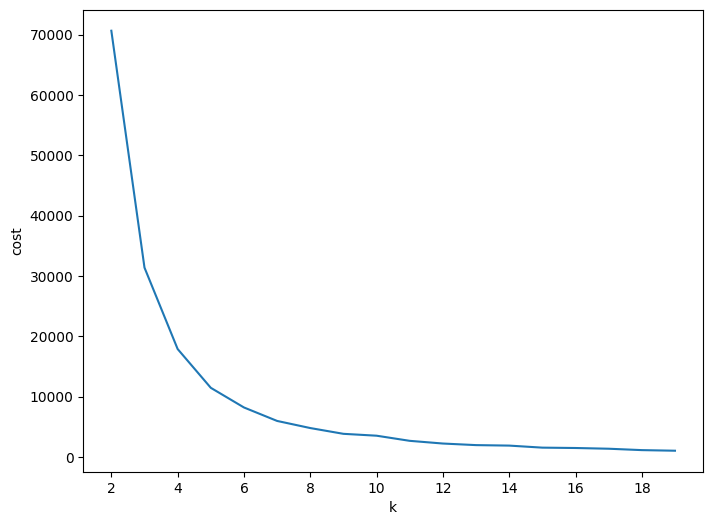

In [ ]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sbs
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In my opinion, sometimes it’s hard to choose the optimal number of the clusters by using the elbow method. As shown in the following Figure, you can choose 3, 5 or even 8. I will choose 3 in this demo.

#### Silhouette analysis

In [ ]:
#@title
#PySpark libraries
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import col, percent_rank, lit
from pyspark.sql.window import Window
from pyspark.sql import DataFrame, Row
from pyspark.sql.types import StructType
from functools import reduce  # For Python 3.x

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

def optimal_k(df_in,index_col,k_min, k_max,num_runs):
    '''
    Determine optimal number of clusters by using Silhoutte Score Analysis.
    :param df_in: the input dataframe
    :param index_col: the name of the index column
    :param k_min: the minmum number of the clusters
    :param k_max: the maxmum number of the clusters
    :param num_runs: the number of runs for each fixed clusters

    :return k: optimal number of the clusters
    :return silh_lst: Silhouette score
    :return r_table: the running results table

    :author: Wenqiang Feng
    :email:  von198@gmail.com
    '''

    start = time.time()
    silh_lst = []
    k_lst = np.arange(k_min, k_max+1)

    r_table = df_in.select(index_col).toPandas()
    r_table = r_table.set_index(index_col)
    centers = pd.DataFrame()

    for k in k_lst:
        silh_val = []
        for run in np.arange(1, num_runs+1):

            # Trains a k-means model.
            kmeans = KMeans()\
                    .setK(k)\
                    .setSeed(int(np.random.randint(100, size=1)))
            model = kmeans.fit(df_in)

            # Make predictions
            predictions = model.transform(df_in)
            r_table['cluster_{k}_{run}'.format(k=k, run=run)]= predictions.select('prediction').toPandas()

            # Evaluate clustering by computing Silhouette score
            evaluator = ClusteringEvaluator()
            silhouette = evaluator.evaluate(predictions)
            silh_val.append(silhouette)

        silh_array=np.asanyarray(silh_val)
        silh_lst.append(silh_array.mean())

    elapsed =  time.time() - start

    silhouette = pd.DataFrame(list(zip(k_lst,silh_lst)),columns = ['k', 'silhouette'])

    print('+------------------------------------------------------------+')
    print("|         The finding optimal k phase took %8.0f s.       |" %(elapsed))
    print('+------------------------------------------------------------+')


    return k_lst[np.argmax(silh_lst, axis=0)], silhouette , r_table

#### Pipeline Architecture

In [ ]:
from pyspark.ml.clustering import KMeans, KMeansModel

kmeans = KMeans() \
          .setK(3) \
          .setFeaturesCol("indexedFeatures")\
          .setPredictionCol("cluster")

# Chain indexer and tree in a Pipeline
pipeline = Pipeline(stages=[featureIndexer, kmeans])

model = pipeline.fit(transformed)

cluster = model.transform(transformed)

#### k-means clusters

In [ ]:
cluster.show()

+--------------------+--------------------+-------+
|            features|     indexedFeatures|cluster|
+--------------------+--------------------+-------+
|[1.0,5.1,3.5,1.4,...|[1.0,5.1,3.5,1.4,...|      1|
|[2.0,4.9,3.0,1.4,...|[2.0,4.9,3.0,1.4,...|      1|
|[3.0,4.7,3.2,1.3,...|[3.0,4.7,3.2,1.3,...|      1|
|[4.0,4.6,3.1,1.5,...|[4.0,4.6,3.1,1.5,...|      1|
|[5.0,5.0,3.6,1.4,...|[5.0,5.0,3.6,1.4,...|      1|
|[6.0,5.4,3.9,1.7,...|[6.0,5.4,3.9,1.7,...|      1|
|[7.0,4.6,3.4,1.4,...|[7.0,4.6,3.4,1.4,...|      1|
|[8.0,5.0,3.4,1.5,...|[8.0,5.0,3.4,1.5,...|      1|
|[9.0,4.4,2.9,1.4,...|[9.0,4.4,2.9,1.4,...|      1|
|[10.0,4.9,3.1,1.5...|[10.0,4.9,3.1,1.5...|      1|
|[11.0,5.4,3.7,1.5...|[11.0,5.4,3.7,1.5...|      1|
|[12.0,4.8,3.4,1.6...|[12.0,4.8,3.4,1.6...|      1|
|[13.0,4.8,3.0,1.4...|[13.0,4.8,3.0,1.4...|      1|
|[14.0,4.3,3.0,1.1...|[14.0,4.3,3.0,1.1...|      1|
|[15.0,5.8,4.0,1.2...|[15.0,5.8,4.0,1.2...|      1|
|[16.0,5.7,4.4,1.5...|[16.0,5.7,4.4,1.5...|      1|
|[17.0,5.4,3

## Clustering Reference 2 & 3

### Setting up a PySpark environment in Colab

Running PySpark in Colab requires a few extra steps compared to just running Python. The Colab runtime will require a few commands to set up the Java Development Kit (JDK), Java paths, Spark paths, and download the packages to run Spark and Hadoop. For this reason, the code below may change to reflect new versions of packages available, if you are trying to recreate the work done please check the Hadoop and Spark versions currently published.

In [ ]:
# set up Java Dev Kit and download Spark and Hadoop 
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://downloads.apache.org/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz

# unpack Spark and Hadoop
!tar xf spark-3.2.0-bin-hadoop3.2.tgz

# set up home paths for Java and Spark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"

--2023-06-01 09:49:56--  https://downloads.apache.org/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
Resolving downloads.apache.org (downloads.apache.org)... 135.181.214.104, 88.99.95.219, 2a01:4f9:3a:2c57::2, ...
Connecting to downloads.apache.org (downloads.apache.org)|135.181.214.104|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-06-01 09:49:57 ERROR 404: Not Found.

tar: spark-3.2.0-bin-hadoop3.2.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


The next step is common to running PySpark locally. In order to find a Spark instance, the findspark package is used.

In [ ]:
# install, import and initialise findspark 
!pip install -q findspark
import findspark
findspark.init()

# set up spark session 
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

This is the last step for setting up PySpark in Colab. It really is that easy to spin up a Spark instance to run some test code and practice your PySpark skills without having to install any local packages. The spark variable will be how we interact with Spark throughout the rest of the project and series.

### Collecting data from an API

With the Spark instance set up and ready to use the next step is importing data. The data used in this project will be from the Solar System API. The clustering done at the end of the project will seek to find similarities between different bodies in space.

The link to the API documentation is included at the end of the article if you are interested in using the API otherwise feel free to use whatever other datasets you choose including CSV, SQL, or any other file type.

In [ ]:
# Import required module
import requests
import json

# base URL 
url = 'https://api.le-systeme-solaire.net/rest/bodies'

# extra parameters, see full docs for more 
params = {'exclude' :'mass,vol,moons,discoveredBy,discoveryDate,alternativeName,axialTilt,avgTemp,mainAnomaly,argPeriapsis,longAscNode,rel,aroundPlanet,sideralOrbit,sideralRotation,dimension,flattening,polarRadius'}

# make request and store as JSON, then get the bodies element (the data we need)
all_data = requests.get(url, params).json()
all_data.get('bodies')

# save file with data from the current request so we do not have to make multiple API calls to reset the data 
with open('data.json', 'w') as f:
    json.dump(all_data, f)

# Check if 'bodies' is in the data
if 'bodies' in all_data:
    print(all_data['bodies'])
else:
    print("Key 'bodies' is not in the data")



[{'id': 'lune', 'name': 'La Lune', 'englishName': 'Moon', 'isPlanet': False, 'semimajorAxis': 384400, 'perihelion': 363300, 'aphelion': 405500, 'eccentricity': 0.0549, 'inclination': 5.145, 'density': 3.344, 'gravity': 1.62, 'escape': 2380.0, 'meanRadius': 1737.0, 'equaRadius': 1738.1, 'bodyType': 'Moon'}, {'id': 'phobos', 'name': 'Phobos', 'englishName': 'Phobos', 'isPlanet': False, 'semimajorAxis': 9378, 'perihelion': 9234, 'aphelion': 9518, 'eccentricity': 0.0151, 'inclination': 1.075, 'density': 1.9, 'gravity': 0.0057, 'escape': 11.39, 'meanRadius': 11.1, 'equaRadius': 13.0, 'bodyType': 'Moon'}, {'id': 'deimos', 'name': 'Deïmos', 'englishName': 'Deimos', 'isPlanet': False, 'semimajorAxis': 23459, 'perihelion': 23456, 'aphelion': 23471, 'eccentricity': 0.0002, 'inclination': 1.075, 'density': 1.75, 'gravity': 0.003, 'escape': 5.556, 'meanRadius': 6.2, 'equaRadius': 7.8, 'bodyType': 'Moon'}, {'id': 'io', 'name': 'Io', 'englishName': 'Io', 'isPlanet': False, 'semimajorAxis': 421800, '

The next step is loading the data into our environment to manipulate it and build a model based on it in PySpark. The data we have is now saved as a JSON file (this is an optional step to avoid abusing the API if anything goes wrong we can just load existing data, however the data can be loaded straight into PySpark, with a link at the end of the article to work that shows this).

When working with PySpark it is useful to set a schema before reading in data so you can be sure what you have pulled from the API is the same as what you are expecting. The PySpark StructTypes allow you to set field types (i.e. string, bool, float) and they also allow you to set whether or not a field is nullable (true, false) depending on if it is essential (id). Finally the StructType allows you to set what fields you want to pull through. This analysis will focus on density, gravity and escape velocity so these are the numeric fields pulled through, an example schema based on these values is given below but please do experiment and see what other fields can produce interesting clusters.

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, BooleanType, FloatType, StringType
from pyspark.sql.types import ArrayType

# set up schema for data to be stored with correct data types and nullable fields 
schema = StructType([
  StructField("bodies", ArrayType(StructType([
      StructField("id", StringType(), False), 
      StructField("englishName", StringType(), True),
      StructField("isPlanet", BooleanType(), True),
      StructField("density", FloatType(), True),
      StructField("gravity", FloatType(), True),
      StructField("escape", FloatType(), True)
  ])), True)
])

# read in JSON file with the schema set 
df = spark.read.json('data.json', schema)

# Explode the bodies column into separate rows
df = df.select(F.explode(df.bodies).alias("bodies"))

# Select the required columns
df = df.select(df.bodies.getField('id').alias('id'), 
               df.bodies.getField('englishName').alias('englishName'), 
               df.bodies.getField('isPlanet').alias('isPlanet'), 
               df.bodies.getField('density').alias('density'), 
               df.bodies.getField('gravity').alias('gravity'), 
               df.bodies.getField('escape').alias('escape'))

df.show(5)


+------+-----------+--------+-------+-------+------+
|    id|englishName|isPlanet|density|gravity|escape|
+------+-----------+--------+-------+-------+------+
|  lune|       Moon|   false|  3.344|   1.62|2380.0|
|phobos|     Phobos|   false|    1.9| 0.0057| 11.39|
|deimos|     Deimos|   false|   1.75|  0.003| 5.556|
|    io|         Io|   false|   3.53|   1.79|   0.0|
|europe|     Europa|   false|   3.01|   1.31|   0.0|
+------+-----------+--------+-------+-------+------+
only showing top 5 rows



This concludes part one of the series. For more on using PySpark, Colab or just general clustering please stick around for Part II.

### Data Cleaning

Part of the cleaning is done before the data is used at all. This covers things like replacing missing values and checking the data types and structures. Other steps are typical to data cleaning or preprocessing but these will be taken care of in the modeling step through the use of a pipeline.

In PySpark there are two kinds of empty values that can cause an error. The first of these is a null value. These are the values for which there is no data. A check can be done to find these values by running a select() count() of only named columns when() the value isnull() according to the pyspark.sql.functions of the same names.



In [ ]:
from pyspark.sql.functions import when, count, isnull
from pyspark.sql.functions import col

# alias all columns 
cols = df.columns

df.show()

# show count of when the column is null for each of those columns
df.select([count(when(isnull(c), c)).alias(c) for c in cols]).show()


+----------+-----------+--------+-------+-------+------+
|        id|englishName|isPlanet|density|gravity|escape|
+----------+-----------+--------+-------+-------+------+
|      lune|       Moon|   false|  3.344|   1.62|2380.0|
|    phobos|     Phobos|   false|    1.9| 0.0057| 11.39|
|    deimos|     Deimos|   false|   1.75|  0.003| 5.556|
|        io|         Io|   false|   3.53|   1.79|   0.0|
|    europe|     Europa|   false|   3.01|   1.31|   0.0|
|  ganymede|   Ganymede|   false|   1.94|  1.428|   0.0|
|  callisto|   Callisto|   false|   1.83|  1.235|   0.0|
|  amalthee|   Amalthea|   false|    3.1|   0.02|   0.0|
|   himalia|    Himalia|   false|    1.0|  0.062|   0.0|
|     elara|      Elara|   false|    1.0|  0.031|   0.0|
|  pasiphae|   Pasiphae|   false|    1.0|  0.022|   0.0|
|    sinope|     Sinope|   false|    1.0|  0.014|   0.0|
|  lysithea|   Lysithea|   false|    1.0|  0.013|   0.0|
|     carme|      Carme|   false|    1.0|  0.017|   0.0|
|    ananke|     Ananke|   fals

The second kind of empty value comes from the reading in of numeric data. The data we have contains three numeric columns and empty values here could be read in as NaN (Not a Number) values. Usually these would be dealth with by imputing values in their place or via deletion. Common methods include row deletion and imputing with the average value for the column. The NaN values can be checked for using the isnan() function.

In [ ]:
from pyspark.sql.functions import isnan

# check schema to find all numeric cols
df.printSchema()  

# list all numeric cols 
num_cols = ['density', 'gravity', 'escape']

# select a count of all the numeric columns where they are NaN and show
df.select([count(when(isnan(c), c)).alias(c) for c in num_cols]).show()

root
 |-- id: string (nullable = true)
 |-- englishName: string (nullable = true)
 |-- isPlanet: boolean (nullable = true)
 |-- density: float (nullable = true)
 |-- gravity: float (nullable = true)
 |-- escape: float (nullable = true)

+-------+-------+------+
|density|gravity|escape|
+-------+-------+------+
|      0|      0|     0|
+-------+-------+------+



The final step in the cleaning of the data is detecting outliers. The problem with outliers in clustering models is their ability to skew even scaled data to form their own cluster of one. The dataset we are using contains a range of very small and very large bodies. The detection of outliers is done manually using visualisation which finds Jupiter to be a severe outlier. The escape velocity, density and gravity are all orders of magnitude larger than almost every other body. For this reason, Jupiter is removed from the dataset to avoid it biasing the algorithm toward building a Jupiter-only cluster.

In [ ]:
import pandas as pd
import plotly.express as px

# convert the data frame to pandas for visualisation
outliers = df.toPandas()

# plot a scatter plot of all the points to find obvious outliers
scatter = px.scatter(outliers, 'gravity', 'escape', hover_name='englishName', template='ggplot2')
scatter.show()

# filter out Jupiter from PySpark DF as it was a clear outlier
df=df.filter(df.id!='jupiter')

# repeat above process to ensure the removal has worked properly
outliers = df.toPandas()

scatter = px.scatter(outliers, 'gravity', 'escape', hover_name='englishName', template='ggplot2')
scatter.show()

The chart showing the outlier is given below with instructions to plot both the before and after in the above snippet:

### Model Building

The model building step involves generating a pipeline. A pipeline can be used in PySpark to solve the preprocessing and training steps in one code block and structure. The pipeline used here will first generate a feature vector (a vector which is the combination of our training features in this case velocity, density and gravity), using a VectorAssembler(). The vector is generated because all work done in PySpark machine learning requires our data to be vectorised. The second step is scaling the data a StandardScaler() this will force all our data into a similar feature space. In so doing all the bodies will be more comparable to one another as the data are all scaled around the mean values. Finally, the KMeans() model is declared and all three of these processes are combined in a Pipeline().



In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline

# set up each processing step with the correct input columns and output
assemble=VectorAssembler(inputCols=num_cols, outputCol='features')
scale=StandardScaler(inputCol='features',outputCol='standardized')
km = KMeans(featuresCol = 'standardized')

# assemble the pipeline 
pipe = Pipeline(stages=[assemble, scale, km])

The problem when using KMeans clustering is the unsupervised nature of the algorithm which gives us little control over the actual modelling process. The algorithm will cluster the data according to a set k value which is set beforehand. To find the best k value silhouette scoring can be performed. Silhouette scores are an indication of how dense and well-defined clusters are, the higher the silhouette score the better. The below code excerpt shows how the clusters are generated and an output box of the scores in this project.

In [ ]:
from pyspark.ml.evaluation import ClusteringEvaluator

# set up evaluator 
evaluator = ClusteringEvaluator()

# test between k=2 and 10 
for k in range(2,10):
  # set the KMeans stage of the pipe to hold each value of K and the random seed = 1 and fit that pipe to data  
  kmeans = pipe.getStages()[-1].setK(k).setSeed(1)  
  model = pipe.fit(df)
  
  # build a preds dataset of each k value
  preds = model.transform(df)

  # silhouette score each prediction set and print formatted output 
  silhouette = evaluator.evaluate(preds)
  print(f'Tested: {k} clusters: {silhouette}')

Tested: 2 clusters: 0.985906445228239
Tested: 3 clusters: 0.9853183536337629
Tested: 4 clusters: 0.9288686572576516
Tested: 5 clusters: 0.9063524257467865
Tested: 6 clusters: 0.8596777095050427
Tested: 7 clusters: 0.8360492437185751
Tested: 8 clusters: -0.7386038523165039
Tested: 9 clusters: 0.8514223592590151


The optimal k value for dense and well-defined clusters here is 2. However, there must be a tradeoff as by clustering into only two clusters the insight drawn from the model is significantly limited. There is a slight reduction in silhouette score as k is increased to 3 however three clusters should give more insight into the underlying data structures. For this reason the value of k=3 is chosen.

### Evaluation

The model built can now be evaluated and the way this is done is through visualisation and the interpretations that can be drawn. Using the three dimensions the model is based upon, the predicted clusters and the status of the body (whether or not it is a planet), the following code snippet can build a 3D chart.



In [ ]:
# set the random seed for the algorithm and the value for k
pipe.getStages()[-1].setK(3).setSeed(1)  

# fit model and transform the data showing a cut of the data to check output
model = pipe.fit(df)
clusters = model.transform(df)
clusters.show(5)

vis_df = clusters.toPandas()

# build figure with 3D numeric dimensions and categorical isPlanet and prediction dimensions
fig = px.scatter_3d(vis_df, x='gravity', y='escape', z='density', color='prediction', symbol='isPlanet', template='ggplot2', hover_name='englishName')
fig.show()

+------+-----------+--------+-------+-------+------+--------------------+--------------------+----------+
|    id|englishName|isPlanet|density|gravity|escape|            features|        standardized|prediction|
+------+-----------+--------+-------+-------+------+--------------------+--------------------+----------+
|  lune|       Moon|   false|  3.344|   1.62|2380.0|[3.34400010108947...|[5.04482713061263...|         0|
|phobos|     Phobos|   false|    1.9| 0.0057| 11.39|[1.89999997615814...|[2.86637892886519...|         0|
|deimos|     Deimos|   false|   1.75|  0.003| 5.556|[1.75,0.003000000...|[2.64008588866244...|         0|
|    io|         Io|   false|   3.53|   1.79|   0.0|[3.52999997138977...|[5.32543034939712...|         0|
|europe|     Europa|   false|   3.01|   1.31|   0.0|[3.00999999046325...|[4.54094771411208...|         0|
+------+-----------+--------+-------+-------+------+--------------------+--------------------+----------+
only showing top 5 rows



The chart shows how well-defined the clusters are, with the bodies being split into large planetary bodies (Saturn and Neptune for example), smaller planetary bodies (including Earth and Mars) and the non-planets (like the Moon and Mars satellite Phobos). This model could now be used in practice to generate an unsupervised classification as to what kind of body something is once we know those measurable features like density, escape velocity and gravity. If other data has been used to cluster a different set of clusters could be produced perhaps to further classify those other bodies. This is an example of how future work could be done to refine the model built here.

However this refining is something for another time. The third and final part of this tutorial will focus on bringing the model into production so that stakeholders can view and interact with the modelling process in a more hands-on fashion. Please do stick around for more!
